In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
cd '../gdrive/MyDrive/SSAC/3조'

/gdrive/.shortcut-targets-by-id/15_BxZVEQYCdGCGiQ5nexpWPc1cgHVe4w/3조


## 파ㅏ파

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
train_data = pd.read_csv('data/train.csv')

In [5]:
# train_data = train_data.sort_values('content_id')

In [6]:
import json

with open('data/brand_dict.json', 'r') as f:
    brand_dict = json.load(f)

with open('data/cat_3_dict.json', 'r') as f:
    cat_3_dict = json.load(f)

with open('data/place_dict.json', 'r') as f:
    place_dict = json.load(f)

with open('data/train_img2vec.json', 'r') as f:
    train_img2vec = json.load(f)

with open('data/train_text2vec_no.json', 'r') as f:
    train_text2vec = json.load(f)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import log_loss, roc_auc_score

In [8]:
sparse_features = [
    'viewer_gender',  
    'content_used',
    'content_cat_1',
    'content_delivery_fee',
    'content_b_pay'
    ]
    
dense_features  = [
    'bid_price', 
    'content_price',
    'content_comment_count',     
    'content_views',       
    'content_likes',
    'adv_item_count',
    'adv_follower_count', 
    'adv_review_count',
    'viewer_age',
    'viewer_following_count',
    'viewer_pay_count',
    "viewer_parcel_post_count",
    'viewer_transfer_count',
    'viewer_chat_count', 
    ]

features = sparse_features + dense_features

In [9]:
# 수동 라벨인코딩
cat_label = {}
for i, cat in enumerate(train_data['content_cat_1'].unique()):
    cat_label[cat] = i

train_data['content_cat_1'] = train_data['content_cat_1'].apply(lambda x: cat_label[x])

train_data['content_delivery_fee'] = train_data['content_delivery_fee'].apply(lambda x: 1 if x=='배송비포함' else 0)

# train_data['viewer_age'] = train_data['viewer_age'].apply(lambda x: x//10 * 10)
# 스케일링, scaler 남겨두기
scaler = StandardScaler()
# scaler = RobustScaler()
train_data[dense_features] = scaler.fit_transform(train_data[dense_features])

In [10]:
import torch
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names, VarLenSparseFeat
from deepctr_torch.models import *
from deepctr_torch.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


## gogo

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_data[features + ['content_id']], train_data['label'], test_size=0.2, random_state=47)

In [12]:
fixlen_feature_columns = [SparseFeat(feat, train_data[feat].nunique())
                            for feat in sparse_features] + [DenseFeat(feat, 1) for feat in dense_features]
                            
feature_names = get_feature_names(fixlen_feature_columns)

feature_columns = fixlen_feature_columns + [DenseFeat('image_vec', 512)] + [DenseFeat('text_vec', 100)]

In [13]:
# input 데이터 생성
train_model_input = {name: X_train[name] for name in feature_names}
train_image_model_input = {'image_vec': np.array([train_img2vec[str(cid)] for cid in X_train['content_id']])}
train_text_model_input = {'text_vec': np.array([train_text2vec[str(cid)] for cid in X_train['content_id']])}
train_model_input = {**train_model_input, **train_image_model_input, **train_text_model_input}

test_model_input = {name: X_test[name] for name in feature_names}
test_image_model_input = {'image_vec': np.array([train_img2vec[str(cid)] for cid in X_test['content_id']])}
test_text_model_input = {'text_vec': np.array([train_text2vec[str(cid)] for cid in X_test['content_id']])}
test_model_input = {**test_model_input, **test_image_model_input, **test_text_model_input}

# Image + Keyword

In [ ]:
# 평균 CTR 계산
average_ctr = train_data['label'].mean()

# RIG 계산 함수
def get_rig(train_y, test_y, pred, avg_ctr):
    prior = log_loss(train_y, [avg_ctr]*len(train_y))

    classifier = log_loss(test_y, pred)

    rig = (prior - classifier) / prior
    return rig

# 평가
def evaluate(pred):
    print("")
    print("test LogLoss", round(log_loss(y_test, pred), 4))
    print("test AUC", round(roc_auc_score(y_test, pred), 4))
    print("test RIG", round(get_rig(y_train, y_test, pred, average_ctr), 4))

In [14]:
# GPU 설정
device = 'cpu'
use_gpu = True
if use_gpu and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

# 모델 정의
model_dfm = DeepFM(feature_columns, feature_columns, use_fm=True, dnn_hidden_units=(512,256), dnn_dropout=0.1,
           dnn_activation='mish', dnn_use_bn=True, task='binary', device=device)
# optimizer, loss 설정
model_dfm.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )
# Early Stoppin 적용
es = EarlyStopping(monitor='val_binary_crossentropy', min_delta=0, verbose=2, patience=5, mode='min')
# 모델 학습
hist_r = model_dfm.fit(x = train_model_input, y = y_train.values , batch_size=512, 
                     epochs=50, verbose=2, validation_split=0.2, callbacks=[es], shuffle=True)

cuda ready...
cuda:0
Train on 470844 samples, validate on 117711 samples, 920 steps per epoch
Epoch 1/50
11s - loss:  0.1390 - binary_crossentropy:  0.1390 - auc:  0.6837 - val_binary_crossentropy:  0.1311 - val_auc:  0.7031
Epoch 2/50
11s - loss:  0.1346 - binary_crossentropy:  0.1346 - auc:  0.7011 - val_binary_crossentropy:  0.1340 - val_auc:  0.7020
Epoch 3/50
11s - loss:  0.1341 - binary_crossentropy:  0.1341 - auc:  0.7087 - val_binary_crossentropy:  0.1327 - val_auc:  0.7099
Epoch 4/50
11s - loss:  0.1336 - binary_crossentropy:  0.1336 - auc:  0.7150 - val_binary_crossentropy:  0.1324 - val_auc:  0.7022
Epoch 5/50
11s - loss:  0.1332 - binary_crossentropy:  0.1332 - auc:  0.7185 - val_binary_crossentropy:  0.1298 - val_auc:  0.7192
Epoch 6/50
11s - loss:  0.1327 - binary_crossentropy:  0.1327 - auc:  0.7220 - val_binary_crossentropy:  0.1300 - val_auc:  0.7193
Epoch 7/50
11s - loss:  0.1326 - binary_crossentropy:  0.1326 - auc:  0.7241 - val_binary_crossentropy:  0.1297 - val_au

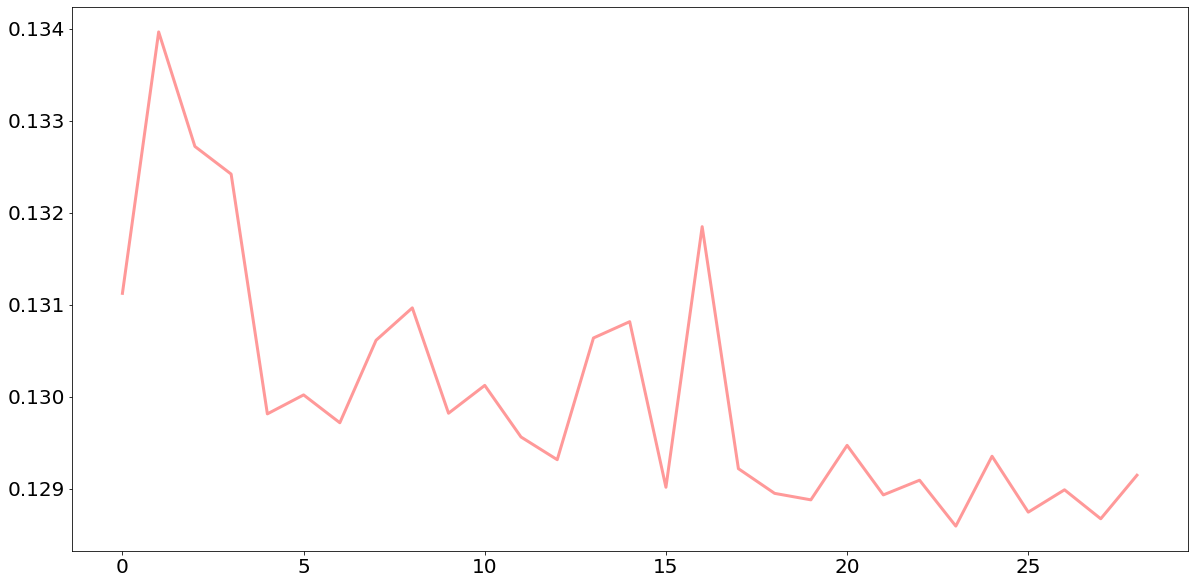

In [15]:
plt.figure(figsize=(20,10))
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.plot(hist_r.history['val_binary_crossentropy'], "#ff9999", linewidth=3)

In [ ]:
hist_r.history['val_auc']

[0.7031050918884634,
 0.7019777293851961,
 0.7099351452795887,
 0.702194190980042,
 0.719175927801216,
 0.7192934084724381,
 0.7174382572652983,
 0.7212803939321991,
 0.7216781444678273,
 0.7196816336771514,
 0.7203590816987633,
 0.7244312190951128,
 0.7259878797247293,
 0.7216811482620904,
 0.7243782895929454,
 0.7255678505514597,
 0.7234918769413675,
 0.7252428195019573,
 0.7283068220129052,
 0.7283307796272527,
 0.725493385311145,
 0.7277837527990317,
 0.7262838327579125,
 0.7307863188335076,
 0.7297076919680077,
 0.7285154873366545,
 0.72875977248511,
 0.7297538435556884,
 0.729834154210643]

In [ ]:
0.1# 25, robust, mish, dropout 0.1, (256,256)
pred_dfm = model_dfm.predict(test_model_input, 512)
evaluate(pred_dfm)


test LogLoss 0.1322
test AUC 0.7288
test RIG 0.0663


In [ ]:
# 25, robust, mish, dropout 0.2, (512,256)
pred_dfm = model_dfm.predict(test_model_input, 512)
evaluate(pred_dfm)


test LogLoss 0.1318
test AUC 0.733
test RIG 0.0688


In [ ]:
# GPU 설정
device = 'cpu'
use_gpu = True
if use_gpu and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

# 모델 정의
model_dfm = DeepFM(feature_columns, feature_columns, use_fm=True, dnn_hidden_units=(512, 256), dnn_dropout=0.1,
           dnn_activation='mish', dnn_use_bn=True, task='binary', device=device)
# optimizer, loss 설정
model_dfm.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )
# Early Stoppin 적용
# es = EarlyStopping(monitor='val_binary_crossentropy', min_delta=0, verbose=2, patience=5, mode='auto')
# 모델 학습
hist_r = model_dfm.fit(x = train_model_input, y = y_train.values , batch_size=512, 
                     epochs=50, verbose=2, validation_split=0.2, shuffle=True)

cuda ready...
cuda:0
Train on 470844 samples, validate on 117711 samples, 920 steps per epoch
Epoch 1/50
11s - loss:  0.1390 - binary_crossentropy:  0.1390 - auc:  0.6837 - val_binary_crossentropy:  0.1311 - val_auc:  0.7031
Epoch 2/50
11s - loss:  0.1346 - binary_crossentropy:  0.1346 - auc:  0.7011 - val_binary_crossentropy:  0.1340 - val_auc:  0.7020
Epoch 3/50
11s - loss:  0.1341 - binary_crossentropy:  0.1341 - auc:  0.7087 - val_binary_crossentropy:  0.1327 - val_auc:  0.7099
Epoch 4/50
10s - loss:  0.1336 - binary_crossentropy:  0.1336 - auc:  0.7150 - val_binary_crossentropy:  0.1324 - val_auc:  0.7022
Epoch 5/50
10s - loss:  0.1332 - binary_crossentropy:  0.1332 - auc:  0.7185 - val_binary_crossentropy:  0.1298 - val_auc:  0.7192
Epoch 6/50
10s - loss:  0.1327 - binary_crossentropy:  0.1327 - auc:  0.7220 - val_binary_crossentropy:  0.1300 - val_auc:  0.7193
Epoch 7/50
10s - loss:  0.1326 - binary_crossentropy:  0.1326 - auc:  0.7241 - val_binary_crossentropy:  0.1297 - val_au

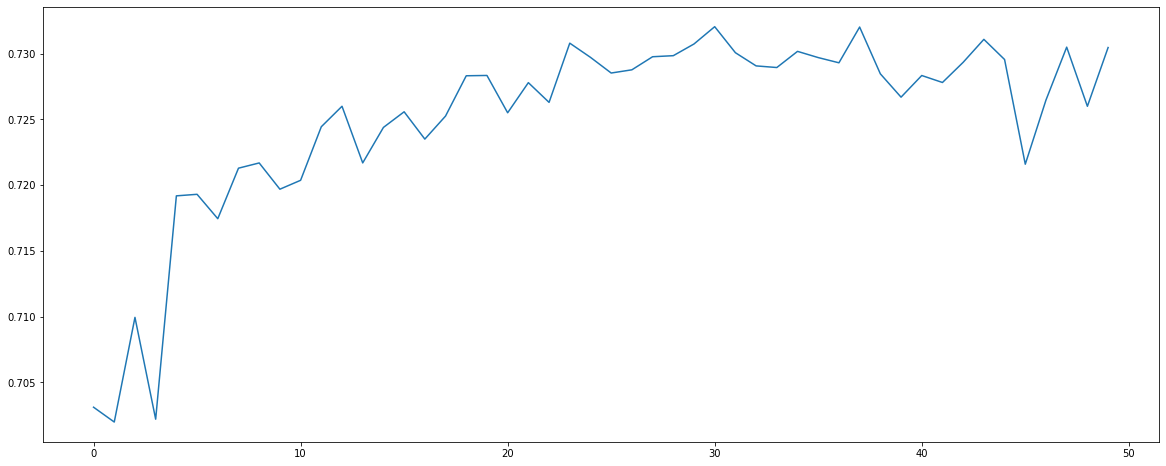

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(hist_r.history['val_auc'])

In [ ]:
# GPU 설정
device = 'cpu'
use_gpu = True
if use_gpu and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

# 모델 정의
model_dfm = DeepFM(feature_columns, feature_columns, use_fm=True, dnn_hidden_units=(512, 256), dnn_dropout=0.1,
           dnn_activation='mish', dnn_use_bn=True, task='binary', device=device)
# optimizer, loss 설정
model_dfm.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )
# Early Stoppin 적용
es = EarlyStopping(monitor='val_binary_crossentropy', min_delta=0, verbose=2, patience=5, mode='auto')
# 모델 학습
hist_r = model_dfm.fit(x = train_model_input, y = y_train.values , batch_size=512, 
                     epochs=50, verbose=2, validation_split=0.2, callbacks=[es], shuffle=True)

cuda ready...
cuda:0
Train on 470844 samples, validate on 117711 samples, 920 steps per epoch
Epoch 1/50
11s - loss:  0.1390 - binary_crossentropy:  0.1390 - auc:  0.6837 - val_binary_crossentropy:  0.1311 - val_auc:  0.7031
Epoch 2/50
11s - loss:  0.1346 - binary_crossentropy:  0.1346 - auc:  0.7011 - val_binary_crossentropy:  0.1340 - val_auc:  0.7020
Epoch 3/50
11s - loss:  0.1341 - binary_crossentropy:  0.1341 - auc:  0.7087 - val_binary_crossentropy:  0.1327 - val_auc:  0.7099
Epoch 4/50
11s - loss:  0.1336 - binary_crossentropy:  0.1336 - auc:  0.7150 - val_binary_crossentropy:  0.1324 - val_auc:  0.7022
Epoch 5/50
11s - loss:  0.1332 - binary_crossentropy:  0.1332 - auc:  0.7185 - val_binary_crossentropy:  0.1298 - val_auc:  0.7192
Epoch 6/50
11s - loss:  0.1327 - binary_crossentropy:  0.1327 - auc:  0.7220 - val_binary_crossentropy:  0.1300 - val_auc:  0.7193
Epoch 7/50
11s - loss:  0.1326 - binary_crossentropy:  0.1326 - auc:  0.7241 - val_binary_crossentropy:  0.1297 - val_au

In [ ]:
pred_dfm = model_dfm.predict(test_model_input, 512)
evaluate(pred_dfm)


test LogLoss 0.1322
test AUC 0.7288
test RIG 0.0663


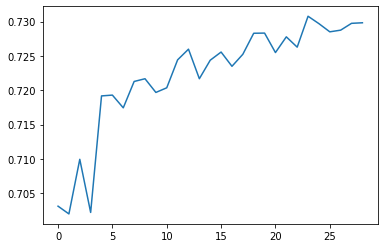

In [ ]:
plt.plot(hist.history['val_auc'])

# Finalize

In [ ]:
device = 'cpu'
use_gpu = True
if use_gpu and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

X_final = X_train.append(X_test)
y_final = y_train.append(y_test)
final_model_input = {name: X_final[name] for name in feature_names}

final_image_model_input = {'image_vec': np.array([train_img2vec[str(cid)] for cid in X_final['content_id']])}
final_text_model_input = {'text_vec': np.array([train_text2vec[str(cid)] for cid in X_final['content_id']])}
final_model_input = {**final_model_input, **final_image_model_input, **final_text_model_input}


# 모델 정의
model_final = DeepFM(feature_columns, feature_columns, use_fm=True, dnn_hidden_units=(512, 256), dnn_dropout=0.1,
           dnn_activation='mish', dnn_use_bn=True, task='binary', device=device)

# optimizer, loss 설정
model_final.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )

# 모델 학습
es = EarlyStopping(monitor='val_auc', min_delta=0, verbose=2, patience=5, mode='max')
hist_f = model_final.fit(x = final_model_input, y = y_final.values , batch_size=512, epochs=50, verbose=2, validation_split=0.2, callbacks=[es], shuffle=True)

cuda ready...
cuda:0
Train on 588555 samples, validate on 147139 samples, 1150 steps per epoch
Epoch 1/50
19s - loss:  0.1377 - binary_crossentropy:  0.1377 - auc:  0.6861 - val_binary_crossentropy:  0.1337 - val_auc:  0.7038
Epoch 2/50
19s - loss:  0.1338 - binary_crossentropy:  0.1338 - auc:  0.7044 - val_binary_crossentropy:  0.1359 - val_auc:  0.7066
Epoch 3/50
19s - loss:  0.1334 - binary_crossentropy:  0.1335 - auc:  0.7112 - val_binary_crossentropy:  0.1338 - val_auc:  0.7071
Epoch 4/50
19s - loss:  0.1331 - binary_crossentropy:  0.1331 - auc:  0.7164 - val_binary_crossentropy:  0.1343 - val_auc:  0.7110
Epoch 5/50
19s - loss:  0.1325 - binary_crossentropy:  0.1325 - auc:  0.7185 - val_binary_crossentropy:  0.1335 - val_auc:  0.7112
Epoch 6/50
19s - loss:  0.1325 - binary_crossentropy:  0.1325 - auc:  0.7203 - val_binary_crossentropy:  0.1338 - val_auc:  0.7105
Epoch 7/50
19s - loss:  0.1320 - binary_crossentropy:  0.1320 - auc:  0.7239 - val_binary_crossentropy:  0.1325 - val_a

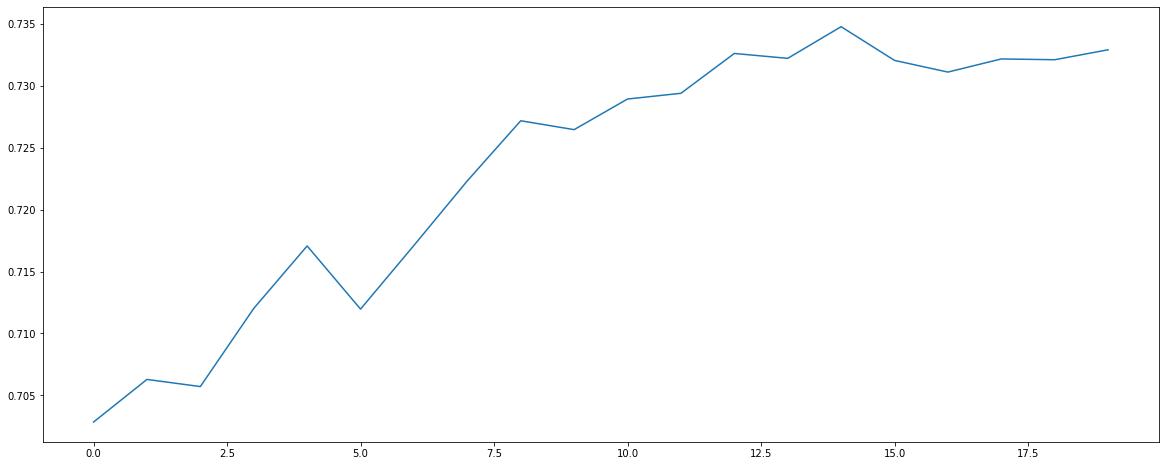

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(hist_f.history['val_auc'])

In [ ]:
import plotly.express as px
fig = px.line(y = hist_f.history['val_auc'], title='Loss')
fig.update_layout(plot_bgcolor='white')
fig['data'][0]['line']['color']="#ff9999"
fig.show()

In [ ]:
# import torch
torch.save(model_final, 'model/deepfm_final.h5')

In [ ]:
import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = 'model/robust_scaler.pkl' 
joblib.dump(scaler, file_name) 

['model/robust_scaler.pkl']

In [ ]:
import lightgbm as lgb
model_lgb = lgb.LGBMClassifier(n_estimators=200, 
                           random_state=47, 
                           learning_rate=0.1,
                           boosting_type='gbdt', 
                           num_leaves=255, 
                           max_depth=-1, 
                           min_data_in_leaf=200, 
                           zero_as_missing=True,
                           objective='binary')
hist_lgb = model_lgb.fit(X_train, y_train)

In [ ]:
hist_lgb.score

<bound method ClassifierMixin.score of LGBMClassifier(min_data_in_leaf=200, n_estimators=200, num_leaves=255,
               objective='binary', random_state=47, zero_as_missing=True)>

In [ ]:
pred_lgb = model_lgb.predict_proba(X_test)[:,1]
evaluate(pred_lgb)


test LogLoss 0.1268
test AUC 0.7694
test RIG 0.1042


In [ ]:
train_img2vec.keys()

dict_keys(['137078818', '137118198', '137118119', '161996984', '163059060', '137072270', '163227168', '162262774', '137118749', '137072639', '137074919', '163228241', '158542956', '163227538', '158464142', '149152299', '162367336', '137073840', '137119359', '137086200', '161753923', '137078130', '139123532', '149152076', '137071467', '137079472', '137083455', '162891275', '162169975', '162629854', '163062465', '163227338', '139128764', '142540474', '142540951', '137119700', '157544827', '157545980', '142709176', '163059949', '137119054', '162169658', '137118036', '161663972', '162806909', '137118398', '162891443', '163059849', '163058920', '152824283', '163242682', '163243484', '137081585', '161384072', '163229021', '161384763', '161754879', '145567590', '162534908', '139123819', '159387567', '161384979', '157755182', '161755596', '160630155', '162892081', '160704489', '160703973', '157342206', '162892200', '153718086', '137089204', '137119473', '161384458', '153718218', '163230170', '

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
for i in tqdm(range(512)):
    X_train[f'img_vec_{i}'] = X_train['content_id'].apply(lambda x: train_img2vec[str(x)][i])
    X_test[f'img_vec_{i}'] = X_test['content_id'].apply(lambda x: train_img2vec[str(x)][i])

  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
for j in tqdm(range(100)):
    X_train[f'txt_vec_{j}'] = X_train['content_id'].apply(lambda x: train_text2vec[str(x)][j])
    X_test[f'txt_vec_{j}'] = X_test['content_id'].apply(lambda x: train_text2vec[str(x)][j])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import lightgbm as lgb

In [ ]:
model_lgb = lgb.LGBMClassifier(n_estimators=200, 
                           random_state=47, 
                           learning_rate=0.1,
                           boosting_type='gbdt', 
                           num_leaves=255, 
                           max_depth=20, 
                           min_data_in_leaf=200, 
                           zero_as_missing=True,
                           objective='binary')
model_lgb.fit(X_train.drop('content_id', axis=1), y_train)

pred_lgb = model_lgb.predict_proba(X_test.drop('content_id', axis=1))[:,1]
evaluate(pred_lgb)


test LogLoss 0.1271
test AUC 0.7671
test RIG 0.102


In [ ]:
evaluate(pred_lgb)


test LogLoss 0.131
test AUC 0.7553
test RIG 0.0748


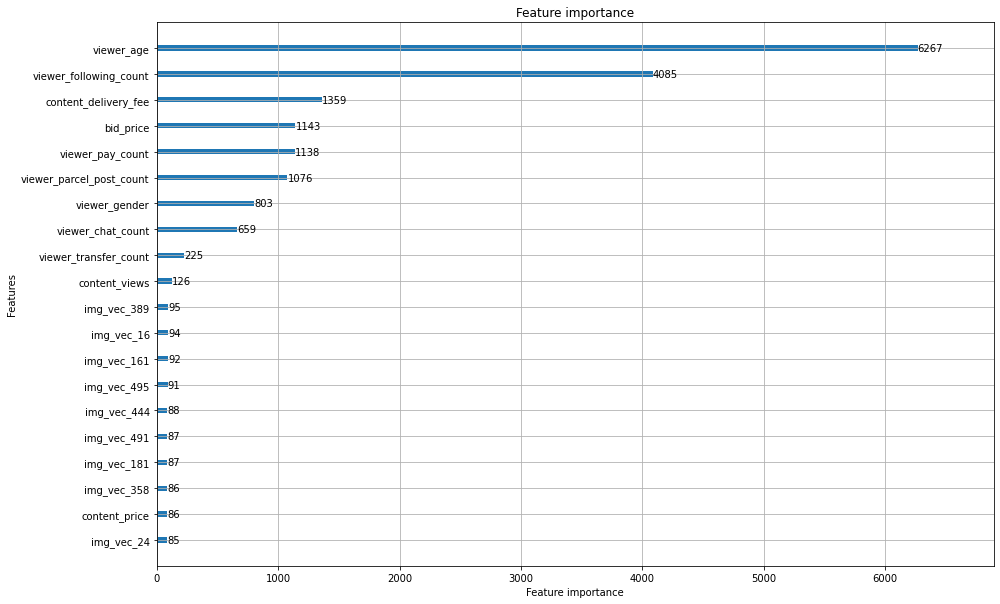

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
lgb.plot_importance(model_lgb, ax=ax, max_num_features=20)

# LGB - No Image/Text

In [16]:
import lightgbm

In [ ]:
X_train['label'] = y_train

In [31]:
parmas = {
    'n_estimators': 200, 
    'random_state': 47, 
    'learning_rate': 0.1,
    'boosting_type': 'gbdt', 
    'num_leaves': 255, 
    'max_depth': 200, 
    'min_data_in_leaf': 200, 
    'zero_as_missing': True,
    'verbose': 1,
    'objective': 'binary'
}
train_dataset = lightgbm.Dataset(X_train, label=y_train)
lgb_hist = lightgbm.cv(parmas, train_dataset, metrics=['auc', 'binary_logloss'], early_stopping_rounds=10)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [33]:
len(lgb_hist['auc-mean'])

94

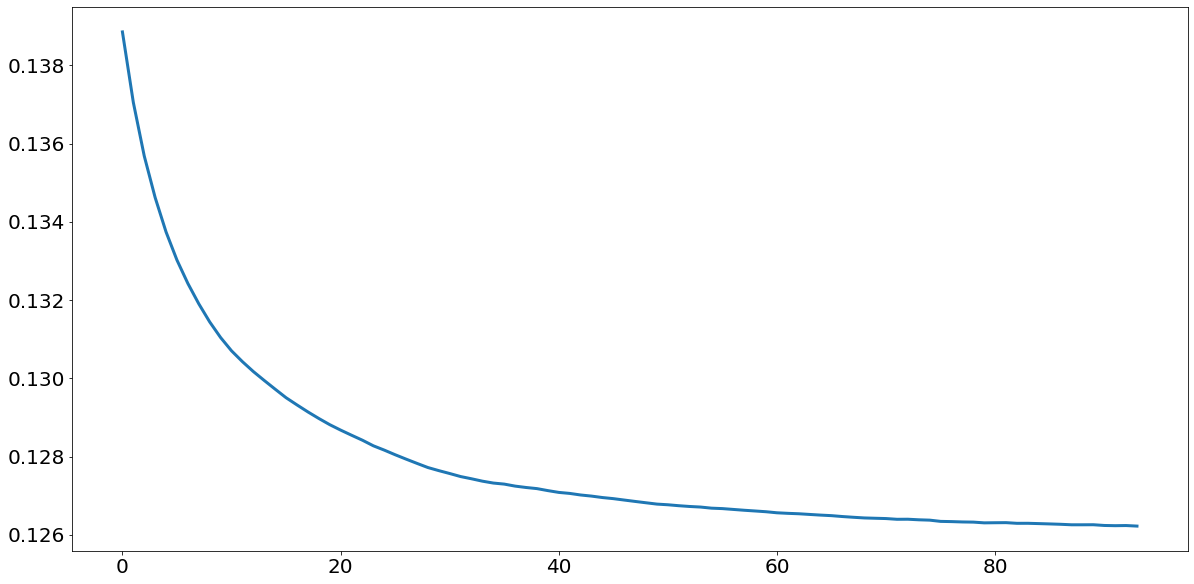

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.plot(lgb_hist['binary_logloss-mean'], linewidth=3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


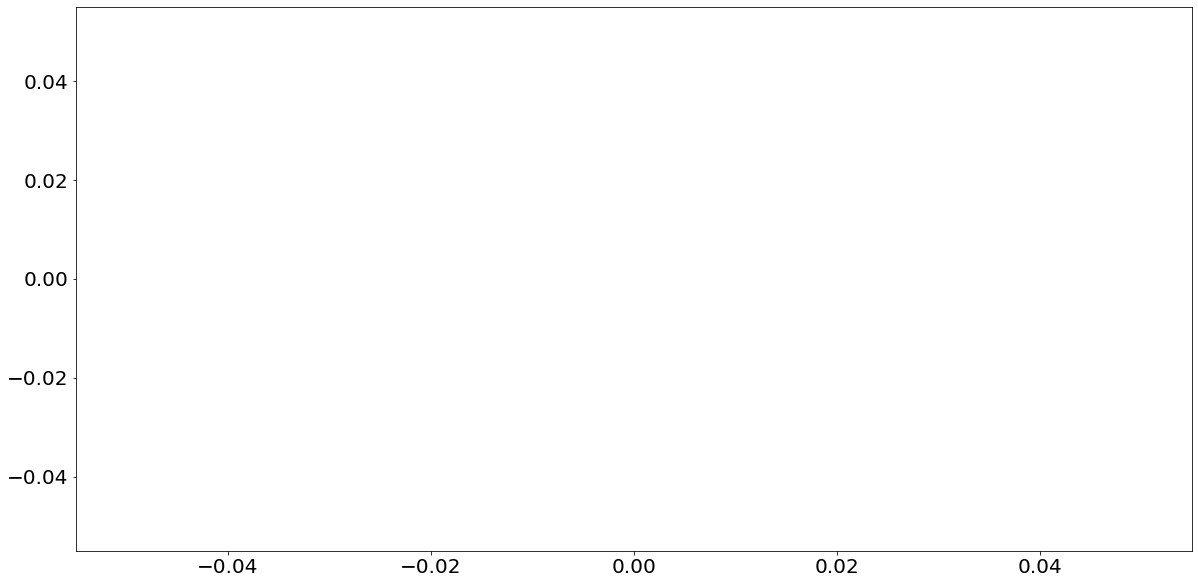

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
sns.lineplot(lgb_hist['binary_logloss-mean'], linewidth=3)

In [ ]:
4

X_

In [ ]:
model_lgb = lgb.LGBMClassifier(n_estimators=200, 
                           random_state=47, 
                           learning_rate=0.1,
                           boosting_type='gbdt', 
                           num_leaves=255, 
                           max_depth=200, 
                           min_data_in_leaf=200, 
                           zero_as_missing=True,
                           objective='binary')
model_lgb.fit(X_train[features], y_train)

pred_lgb = model_lgb.predict_proba(X_test[features])[:,1]
evaluate(pred_lgb)


test LogLoss 0.1272
test AUC 0.7666
test RIG 0.1012


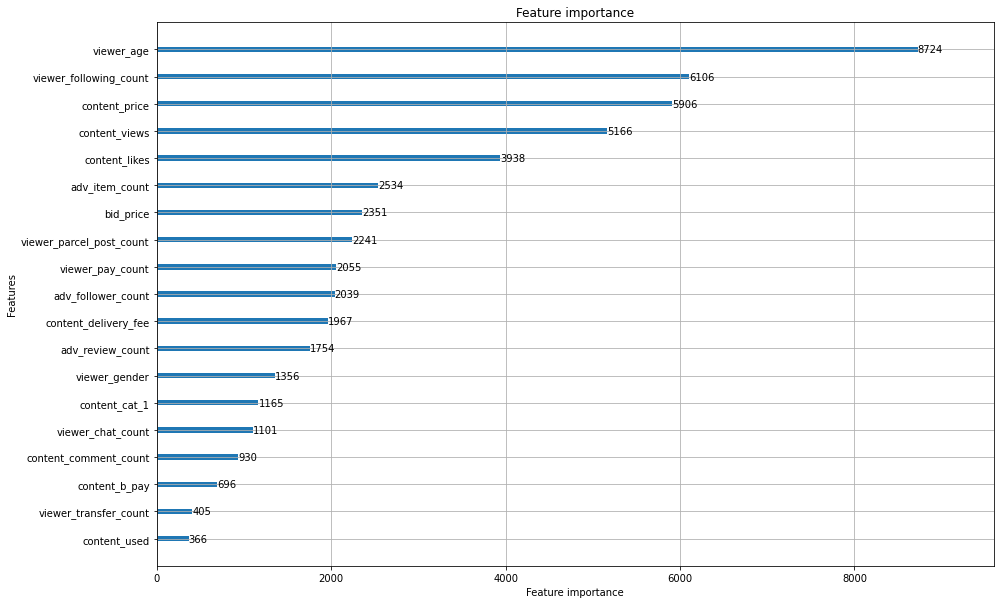

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
lgb.plot_importance(model_lgb_no, ax=ax, max_num_features=20)

In [ ]:
import os
ctr_df = pd.DataFrame()
for file_name in os.listdir('data/의류'):
    if 'ctr' in file_name:
        temp = pd.read_csv('data/의류/' + file_name)
        ctr_df = ctr_df.append(temp)

In [ ]:
ctr_df.reset_index(drop=True)

,content_id,gender,age,ctr
0,102335249,1,10,0.010955
1,172622490,1,10,0.022555
2,175359651,1,10,0.017508
3,169842056,1,10,0.005548
4,169341376,1,10,0.056082
...,...,...,...,...
15413015,157019585,2,79,0.014829
15413016,174793047,2,79,0.016890
15413017,175836854,2,79,0.016438
15413018,172639475,2,79,0.013488


In [ ]:
from itertools import product

# 유저 정보 (median 사용)
users = {'bid_price': [50],
         'viewer_gender': [1,2],
         'viewer_age': range(10, 80),
         'viewer_chat_count': [0.0],
        'viewer_following_count': [1.0],
        'viewer_parcel_post_count': [0.0],
        'viewer_pay_count': [0.0],
        'viewer_transfer_count': [0.0]
         }

# 유저 생성
user_list = []
for i, values in enumerate(list(product(*users.values()))):
    user = dict(zip(users.keys(), values))
    user_list.append(user)
    
# 위에서 생성한 유저 140명에 대해 CTR 예측
print('CTR 예측 시작')

# CTR 저장할 df 생성
result_df = pd.DataFrame()
for demo_user in tqdm(user_list):
    # 각 유저에 대한 ctr 저장할 df 생성
    user_ctr_df = pd.DataFrame({'content_id': df.content_id, 
                                'gender': demo_user['viewer_gender'],
                                'age': demo_user['viewer_age'],
                                })
    
    # 예측 input으로 사용할 데이터만 뽑기
    candidates_df = df[candidates].copy()        
    
    # 각 유저마다 특성을 입력(나이, 성별 등)
    for feat in demo_user.keys():
        candidates_df[feat] = demo_user[feat]
    # 학습했을때와 같은 순서로 컬럼 정렬
    candidates_df = candidates_df[features]

    # Label Encoding
    candidates_df['content_cat_1'] = candidates_df['content_cat_1'].apply(lambda x: cat_label[x])
    # Standard Scaling
    candidates_df[continuous] = scaler.transform(candidates_df[continuous])
    
    # DeepFM input 형태에 맞게(정형 데이터)
    candidates_input = {name: candidates_df[name] for name in features}
    # 정형 + 비정형 input 합치기
    predict_input.update(candidates_input)

    # CTR 예측
    CTR_dfm = model_dfm.predict(predict_input, 512)

    # 예측한 CTR 저장
    user_ctr_df['ctr'] = CTR_dfm
    result_df = result_df.append(user_ctr_df)

# **Image**

In [ ]:
device = 'cpu'
use_gpu = True
if use_gpu and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

# 모델 정의
model_dfm = DeepFM(fixlen_feature_columns, fixlen_feature_columns,  dnn_hidden_units=(512, 256), dnn_dropout=0.0,
           dnn_activation='relu', dnn_use_bn=True, task='binary')

# optimizer, loss 설정
model_dfm.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )

# 모델 학습
es = EarlyStopping(monitor='val_binary_crossentropy', min_delta=0, verbose=2, patience=5, mode='auto')
hist = model_dfm.fit(x = train_model_input, y = y_train.values , batch_size=512, epochs=50, verbose=2, validation_split=0.2, callbacks=[es], shuffle=True)


cuda ready...
cpu
Train on 470844 samples, validate on 117711 samples, 920 steps per epoch
Epoch 1/50
21s - loss:  0.1376 - binary_crossentropy:  0.1376 - auc:  0.6863 - val_binary_crossentropy:  0.1310 - val_auc:  0.7041
Epoch 2/50
20s - loss:  0.1349 - binary_crossentropy:  0.1348 - auc:  0.6999 - val_binary_crossentropy:  0.1313 - val_auc:  0.7050
Epoch 3/50
21s - loss:  0.1343 - binary_crossentropy:  0.1343 - auc:  0.7055 - val_binary_crossentropy:  0.1314 - val_auc:  0.7013
Epoch 4/50
21s - loss:  0.1338 - binary_crossentropy:  0.1338 - auc:  0.7096 - val_binary_crossentropy:  0.1305 - val_auc:  0.7096
Epoch 5/50
22s - loss:  0.1335 - binary_crossentropy:  0.1335 - auc:  0.7141 - val_binary_crossentropy:  0.1311 - val_auc:  0.7083
Epoch 6/50
22s - loss:  0.1332 - binary_crossentropy:  0.1332 - auc:  0.7170 - val_binary_crossentropy:  0.1315 - val_auc:  0.7142
Epoch 7/50
22s - loss:  0.1329 - binary_crossentropy:  0.1328 - auc:  0.7206 - val_binary_crossentropy:  0.1302 - val_auc: 

In [ ]:
pred_dfm = model_dfm.predict(test_model_input, 512)
evaluate(pred_dfm)


test LogLoss 0.1328
test AUC 0.7287
test RIG 0.0619


In [ ]:
pred_dfm = model_dfm.predict(test_model_input, 512)
evaluate(pred_dfm)


test LogLoss 0.1338
test AUC 0.7149
test RIG 0.0549


## 정규표현식으로 키워드 전처리

In [ ]:
device = 'cpu'
use_gpu = True
if use_gpu and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

# 모델 정의
model_dfm = DeepFM(linear_feature_columns, dnn_feature_columns,  dnn_hidden_units=(512, 256), dnn_dropout=0.0,
           dnn_activation='mish', dnn_use_bn=True, task='binary')

# optimizer, loss 설정
model_dfm.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )

# 모델 학습
es = EarlyStopping(monitor='val_binary_crossentropy', min_delta=0, verbose=2, patience=5, mode='auto')
hist = model_dfm.fit(x = train_model_input, y = y_train.values , batch_size=1024, epochs=50, verbose=2, validation_split=0.2, callbacks=[es], shuffle=True)

pred_dfm = model_dfm.predict(test_model_input, 512)
evaluate(pred_dfm)

cpu
Train on 470844 samples, validate on 117711 samples, 460 steps per epoch
Epoch 1/50
32s - loss:  0.1622 - binary_crossentropy:  0.1603 - auc:  0.6683 - val_binary_crossentropy:  0.1316 - val_auc:  0.6981
Epoch 2/50
31s - loss:  0.1343 - binary_crossentropy:  0.1343 - auc:  0.7019 - val_binary_crossentropy:  0.1320 - val_auc:  0.6944
Epoch 3/50
31s - loss:  0.1333 - binary_crossentropy:  0.1333 - auc:  0.7113 - val_binary_crossentropy:  0.1309 - val_auc:  0.7064
Epoch 4/50
32s - loss:  0.1325 - binary_crossentropy:  0.1325 - auc:  0.7187 - val_binary_crossentropy:  0.1307 - val_auc:  0.7102
Epoch 5/50
32s - loss:  0.1317 - binary_crossentropy:  0.1317 - auc:  0.7260 - val_binary_crossentropy:  0.1301 - val_auc:  0.7175
Epoch 6/50
31s - loss:  0.1314 - binary_crossentropy:  0.1315 - auc:  0.7280 - val_binary_crossentropy:  0.1305 - val_auc:  0.7114
Epoch 7/50
32s - loss:  0.1309 - binary_crossentropy:  0.1309 - auc:  0.7320 - val_binary_crossentropy:  0.1297 - val_auc:  0.7202
Epoch 

## 그냥 0~2000 라벨링

In [ ]:
from deepctr_torch.models import DeepFM

device = 'cpu'
use_gpu = True
if use_gpu and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

# 모델 정의
model_dfm = DeepFM(linear_feature_columns, dnn_feature_columns,  dnn_hidden_units=(512, 256), dnn_dropout=0.0,
           dnn_activation='relu', dnn_use_bn=True, task='binary')

# optimizer, loss 설정
model_dfm.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )

# 모델 학습
es = EarlyStopping(monitor='val_binary_crossentropy', min_delta=0, verbose=2, patience=5, mode='auto')
hist = model_dfm.fit(x = train_model_input, y = y_train.values , batch_size=1024, epochs=50, verbose=2, validation_split=0.2, callbacks=[es], shuffle=True)

pred_dfm = model_dfm.predict(test_model_input, 512)
evaluate(pred_dfm)

cpu
Train on 470844 samples, validate on 117711 samples, 460 steps per epoch
Epoch 1/50
21s - loss:  0.1440 - binary_crossentropy:  0.1440 - auc:  0.6848 - val_binary_crossentropy:  0.1306 - val_auc:  0.7088
Epoch 2/50
20s - loss:  0.1328 - binary_crossentropy:  0.1328 - auc:  0.7191 - val_binary_crossentropy:  0.1309 - val_auc:  0.7051
Epoch 3/50
20s - loss:  0.1316 - binary_crossentropy:  0.1316 - auc:  0.7291 - val_binary_crossentropy:  0.1300 - val_auc:  0.7170
Epoch 4/50
20s - loss:  0.1307 - binary_crossentropy:  0.1307 - auc:  0.7381 - val_binary_crossentropy:  0.1299 - val_auc:  0.7190
Epoch 5/50
20s - loss:  0.1299 - binary_crossentropy:  0.1299 - auc:  0.7441 - val_binary_crossentropy:  0.1304 - val_auc:  0.7193
Epoch 6/50
20s - loss:  0.1294 - binary_crossentropy:  0.1294 - auc:  0.7479 - val_binary_crossentropy:  0.1296 - val_auc:  0.7261
Epoch 7/50
20s - loss:  0.1291 - binary_crossentropy:  0.1291 - auc:  0.7500 - val_binary_crossentropy:  0.1293 - val_auc:  0.7265
Epoch 

In [ ]:
from deepctr_torch.models import DeepFM

device = 'cpu'
use_gpu = True
if use_gpu and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

# 모델 정의
model_dfm = DeepFM(linear_feature_columns, dnn_feature_columns,  dnn_hidden_units=(512, 256), dnn_dropout=0.0,
           dnn_activation='mish', dnn_use_bn=True, task='binary')

# optimizer, loss 설정
model_dfm.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy", "auc"], )

# 모델 학습
es = EarlyStopping(monitor='val_binary_crossentropy', min_delta=0, verbose=2, patience=5, mode='auto')
hist = model_dfm.fit(x = train_model_input, y = y_train.values , batch_size=1024, epochs=50, verbose=2, validation_split=0.2, callbacks=[es], shuffle=True)

pred_dfm = model_dfm.predict(test_model_input, 512)
evaluate(pred_dfm)

cpu
Train on 470844 samples, validate on 117711 samples, 460 steps per epoch
Epoch 1/50
32s - loss:  0.1557 - binary_crossentropy:  0.1557 - auc:  0.6768 - val_binary_crossentropy:  0.1307 - val_auc:  0.7105
Epoch 2/50
31s - loss:  0.1331 - binary_crossentropy:  0.1331 - auc:  0.7160 - val_binary_crossentropy:  0.1309 - val_auc:  0.7076
Epoch 3/50
32s - loss:  0.1320 - binary_crossentropy:  0.1320 - auc:  0.7250 - val_binary_crossentropy:  0.1304 - val_auc:  0.7170
Epoch 4/50
31s - loss:  0.1315 - binary_crossentropy:  0.1315 - auc:  0.7313 - val_binary_crossentropy:  0.1305 - val_auc:  0.7170
Epoch 5/50
32s - loss:  0.1305 - binary_crossentropy:  0.1305 - auc:  0.7385 - val_binary_crossentropy:  0.1311 - val_auc:  0.7162
Epoch 6/50
32s - loss:  0.1300 - binary_crossentropy:  0.1300 - auc:  0.7422 - val_binary_crossentropy:  0.1296 - val_auc:  0.7232
Epoch 7/50
31s - loss:  0.1296 - binary_crossentropy:  0.1296 - auc:  0.7462 - val_binary_crossentropy:  0.1298 - val_auc:  0.7218
Epoch 

In [ ]:
pred_dfm = model_dfm.predict(test_model_input, 512)
evaluate(pred)

In [ ]:
test_model_input['content_keyword']

array([[ 978,  979,  651,  962,  980],
       [1011, 1930, 1951, 1941, 1015],
       [ 143,  356,    0,    0,    0],
       ...,
       [  17,    0,    0,    0,    0],
       [1132, 1133, 1134, 1135,    0],
       [1039, 1685, 1026, 1691,    0]])

In [ ]:
roc_auc_score(y_test, pred_dfm)

0.7320180735472988

In [ ]:
average_ctr = train_data['label'].mean()

# 평가지표 함수

def get_rig(train_y, test_y, pred, avg_ctr):
    prior = log_loss(train_y, [avg_ctr]*len(train_y))

    classifier = log_loss(test_y, pred)

    rig = (prior - classifier) / prior
    return rig

def evaluate(pred):
    print("")
    print("test LogLoss", round(log_loss(y_test, pred), 4))
    print("test AUC", round(roc_auc_score(y_test, pred), 4))
    print("test RIG", round(get_rig(y_train, y_test, pred, average_ctr), 4))